In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from skopt import BayesSearchCV
import subprocess
import matplotlib.pyplot as plt
import math  
import sklearn.metrics
import shap
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns

# Feature pre-processing
#### Numerical Features
'id', 'scrape_id', 'host_id', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 
'host_total_listings_count','latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price',
'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews',
'number_of_reviews_ltm','number_of_reviews_l30d','review_scores_rating','review_scores_accuracy',
'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
'review_scores_value','calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms','reviews_per_month'

#### Categorical Features
'source', 'host_response_time', 'host_is_superhost', 'host_neighbourhood', 'host_has_profile_pic', 
'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 
'property_type','room_type', 'has_availability', 'instant_bookable', 'host_location'

#### Date Features
'last_scraped', 'host_since', 'calendar_last_scraped', 'first_review', 'last_review'

#### Text Features
'listing_url', 'name', 'description', 'neighbourhood_overview', 'picture_url', 
'host_url', 'host_name', 'host_about', 'hosr_thumbnail_url', 'host_picture_url', 
'host_verifications', 'bathrooms_text', 'amenities'

#### Empty Columns
'calendar_updated', 'bathrooms'

#### Dummu Column
'license'

In [2]:
data = pd.read_csv('listings.csv')
airbnb = pd.read_csv('airbnb_4.csv')
# Merge the two dataframes based on the 'id' column, concatenate 3 new features
merged_df = pd.merge(data, airbnb[['id', 'average_nearest_price', 'within_radius', 'bus_radius']], on='id')

In [3]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4887 entries, 0 to 4886
Data columns (total 78 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            4887 non-null   int64  
 1   listing_url                                   4887 non-null   object 
 2   scrape_id                                     4887 non-null   int64  
 3   last_scraped                                  4887 non-null   object 
 4   source                                        4887 non-null   object 
 5   name                                          4887 non-null   object 
 6   description                                   4866 non-null   object 
 7   neighborhood_overview                         3422 non-null   object 
 8   picture_url                                   4887 non-null   object 
 9   host_id                                       4887 non-null   i

### Since we face to new host, we select the features that is relevant to the feature price, ignored empty columns, identification features (id, name, etc.), high correlated featurs (host_listings_count, minimum_minimum_nights, etc), and past experience features, etc.

In [4]:
# 19 selected features
columns = ['latitude', 'longitude', 'host_total_listings_count','host_has_profile_pic', 
           'host_identity_verified','neighbourhood_cleansed', 'property_type', 'room_type', 
           'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'has_availability', 'instant_bookable',
            'average_nearest_price', 'within_radius', 'bus_radius']
df = merged_df[columns].copy()

# Data Pre-processing

### 1. Count the number of NA in each column, and drop all rows have NA.

In [5]:
def count_na_by_column(data):
    for column in data.columns:
        print(column + ":", data[column].isna().sum())
count_na_by_column(df)
df = df.dropna()

latitude: 0
longitude: 0
host_total_listings_count: 0
host_has_profile_pic: 0
host_identity_verified: 0
neighbourhood_cleansed: 0
property_type: 0
room_type: 0
accommodates: 0
bathrooms_text: 2
bedrooms: 299
beds: 44
amenities: 0
price: 0
has_availability: 0
instant_bookable: 0
average_nearest_price: 5
within_radius: 0
bus_radius: 0


### 2. Convert the price to numeric values [extreme value removed]

In [6]:
def prices_to_numbers (price_string):
    price_numeric = float(str(price_string).replace(',', '').split('$')[-1])
    return price_numeric
df['price'] = df['price'].apply(prices_to_numbers)
df.price.head(2)

0    157.0
1    150.0
Name: price, dtype: float64

In [7]:
q_high = df['price'].quantile(0.95)
q_low = df['price'].quantile(0.05)
df = df[(df['price'] <= q_high) & (df['price'] >= q_low)]

### 3. Convert bool value to numeric.

In [8]:
from sklearn.preprocessing import LabelEncoder
boolean_cols = ['host_has_profile_pic',
               'host_identity_verified',
               'has_availability',
               'instant_bookable',
               'within_radius',
               'bus_radius']

le = LabelEncoder()

for col in boolean_cols:
    col_encoded = le.fit_transform(df[col])
    df[col] = le.fit_transform(df[col])
    # get the mappings of the encoded values
    mappings = dict(zip(range(len(le.classes_)), le.classes_))

    # print the mappings
    print("Mappings for %s: %s\n" % (col, mappings))

Mappings for host_has_profile_pic: {0: 'f', 1: 't'}

Mappings for host_identity_verified: {0: 'f', 1: 't'}

Mappings for has_availability: {0: 'f', 1: 't'}

Mappings for instant_bookable: {0: 'f', 1: 't'}

Mappings for within_radius: {0: False, 1: True}

Mappings for bus_radius: {0: False, 1: True}



### 4. Extract all kind of amenities from the text, create new amenity boolean features.

In [9]:
all_amenities = []
amenities_list = df.amenities.unique()

for i in range(len(amenities_list)):
    amenities = amenities_list[i].split(",")
    for ft in amenities:
        for amen in ft.split('"'):
            if amen != "[" and amen != "]" and amen not in all_amenities:
                all_amenities.append(amen)

We manually selected a few hot amenities to create new boolean features.

In [10]:
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
#df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4095 entries, 0 to 4886
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   latitude                   4095 non-null   float64
 1   longitude                  4095 non-null   float64
 2   host_total_listings_count  4095 non-null   int64  
 3   host_has_profile_pic       4095 non-null   int32  
 4   host_identity_verified     4095 non-null   int32  
 5   neighbourhood_cleansed     4095 non-null   object 
 6   property_type              4095 non-null   object 
 7   room_type                  4095 non-null   object 
 8   accommodates               4095 non-null   int64  
 9   bathrooms_text             4095 non-null   object 
 10  bedrooms                   4095 non-null   float64
 11  beds                       4095 non-null   float64
 12  amenities                  4095 non-null   object 
 13  price                      4095 non-null   float

Replacing nulls with zeros for new columns

In [12]:
cols_to_replace_nulls = df.iloc[:,19:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

Next, we view the value set for all new columns

In [13]:
def printValuesForEachColumn(data):
    for amenity_column in data.columns[20:]:
        print(amenity_column, set(data[amenity_column]))
printValuesForEachColumn(df)

high_end_electronics {0.0, 1.0}
bbq {0.0, 1.0}
balcony {0.0, 1.0}
nature_and_views {0.0, 1.0}
bed_linen {0.0, 1.0}
breakfast {0.0, 1.0}
tv {0.0, 1.0}
coffee_machine {0.0, 1.0}
cooking_basics {0.0, 1.0}
white_goods {0.0, 1.0}
elevator {0.0, 1.0}
gym {0.0, 1.0}
child_friendly {0.0, 1.0}
parking {0.0, 1.0}
outdoor_space {0.0, 1.0}
host_greeting {0.0, 1.0}
hot_tub_sauna_or_pool {0.0, 1.0}
internet {0.0, 1.0}
long_term_stays {0.0, 1.0}
pets_allowed {0.0, 1.0}
private_entrance {0.0, 1.0}
secure {0.0, 1.0}
smoking_allowed {0.0, 1.0}


We did not observe any column contains a single value only.

Dropping the original amenities column

In [14]:
df.drop('amenities', axis=1, inplace=True)

### 5. Displays the property type of listings

In [15]:
property_type_counts = df.property_type.value_counts()
property_type_counts

Entire condo                          1189
Entire rental unit                     792
Entire home                            634
Entire guest suite                     545
Private room in home                   319
Entire loft                            119
Entire townhouse                        80
Private room in rental unit             70
Private room in condo                   65
Entire guesthouse                       62
Entire serviced apartment               57
Private room in villa                   27
Private room in townhouse               23
Private room in guest suite             16
Entire villa                            11
Entire bungalow                         10
Room in boutique hotel                   9
Private room in bed and breakfast        8
Entire place                             6
Room in aparthotel                       5
Private room in bungalow                 4
Entire timeshare                         4
Entire cottage                           4
Private roo

Grouping property types whose low counts might be insignificant and not provide us with enough information.
Thus, grouping property types that have counts that are < 20 into 'Other'.

In [16]:
df.loc[df.property_type.isin(property_type_counts[property_type_counts<20].keys()), 'property_type'] = 'Other'
df.property_type.value_counts()

Entire condo                   1189
Entire rental unit              792
Entire home                     634
Entire guest suite              545
Private room in home            319
Entire loft                     119
Other                           113
Entire townhouse                 80
Private room in rental unit      70
Private room in condo            65
Entire guesthouse                62
Entire serviced apartment        57
Private room in villa            27
Private room in townhouse        23
Name: property_type, dtype: int64

### 6. Extract the features of bathrooms number and bathroom type from the text column 'bathrooms_text'

In [17]:
list(set(df.bathrooms_text))[0:10]

['4.5 baths',
 '3.5 baths',
 '1 bath',
 '4 baths',
 '1 private bath',
 '0 baths',
 '3 baths',
 '3 shared baths',
 '3.5 shared baths',
 'Shared half-bath']

In [18]:
def convertBathrooms(row):  
    if 'private' in row['bathrooms_text'].lower():
        return 'private'
    elif 'shared' in row['bathrooms_text'].lower():
        return 'shared'
    return 'unknown'

df['bathrooms_type'] = df.apply(lambda row: convertBathrooms(row), axis=1)
df.bathrooms_type.value_counts()

unknown    3587
private     254
shared      254
Name: bathrooms_type, dtype: int64

Now we extract the bathroom number

In [19]:
def calculateBathroomNum(row):  
    if 'half' in row['bathrooms_text'].lower() or 'Half' in row['bathrooms_text'].lower():
        return 0.5
    return float(row['bathrooms_text'].split(" ")[0])

df['bathrooms_number'] = df.apply(lambda row: calculateBathroomNum(row), axis=1)
df.bathrooms_number.value_counts()

1.0    3023
2.0     704
1.5     191
2.5     107
3.0      34
3.5      16
4.0       8
4.5       4
0.0       3
0.5       2
6.0       1
5.0       1
7.0       1
Name: bathrooms_number, dtype: int64

Drop the original column 'bathrooms_text'

In [20]:
df.drop('bathrooms_text', axis=1, inplace=True)

### 7. Encode other categorical features.

In [21]:
boolean_cols = ['neighbourhood_cleansed',
               'property_type',
               'room_type',
               'bathrooms_type']

le = LabelEncoder()

for col in boolean_cols:
    col_encoded = le.fit_transform(df[col])
    df[col] = le.fit_transform(df[col])
    # get the mappings of the encoded values
    mappings = dict(zip(range(len(le.classes_)), le.classes_))

    # print the mappings
    print("Mappings for %s: %s\n" % (col, mappings))

Mappings for neighbourhood_cleansed: {0: 'Arbutus Ridge', 1: 'Downtown', 2: 'Downtown Eastside', 3: 'Dunbar Southlands', 4: 'Fairview', 5: 'Grandview-Woodland', 6: 'Hastings-Sunrise', 7: 'Kensington-Cedar Cottage', 8: 'Kerrisdale', 9: 'Killarney', 10: 'Kitsilano', 11: 'Marpole', 12: 'Mount Pleasant', 13: 'Oakridge', 14: 'Renfrew-Collingwood', 15: 'Riley Park', 16: 'Shaughnessy', 17: 'South Cambie', 18: 'Strathcona', 19: 'Sunset', 20: 'Victoria-Fraserview', 21: 'West End', 22: 'West Point Grey'}

Mappings for property_type: {0: 'Entire condo', 1: 'Entire guest suite', 2: 'Entire guesthouse', 3: 'Entire home', 4: 'Entire loft', 5: 'Entire rental unit', 6: 'Entire serviced apartment', 7: 'Entire townhouse', 8: 'Other', 9: 'Private room in condo', 10: 'Private room in home', 11: 'Private room in rental unit', 12: 'Private room in townhouse', 13: 'Private room in villa'}

Mappings for room_type: {0: 'Entire home/apt', 1: 'Hotel room', 2: 'Private room', 3: 'Shared room'}

Mappings for bathr

In [22]:
df.to_csv('airbnb_model_fitting.csv', index=False)

## Feature Selection

In [23]:
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1, train_size = 0.9,  random_state=42)

In [24]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
import warnings
warnings.filterwarnings("ignore")

selector = SelectKBest(mutual_info_regression, k=11)

X_new = selector.fit_transform(X_train, y_train)

X_train_selected = X_train.iloc[:, selector.get_support(indices=True)]
X_test_selected = X_test.iloc[:, selector.get_support(indices=True)]

X_train_selected['bus_radius'] = X_train.iloc[:, X_train.columns.get_loc('bus_radius')]
X_train_selected['within_radius'] = X_train['within_radius']
X_train_selected['average_nearest_price'] = X_train['average_nearest_price']
X_train_selected['longitude'] = X_train['longitude']

X_test_selected['bus_radius'] = X_test['bus_radius']
X_test_selected['within_radius'] = X_test['within_radius']
X_test_selected['average_nearest_price'] = X_test['average_nearest_price']
X_test_selected['longitude'] = X_test['longitude']

X_train_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3685 entries, 4657 to 3839
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   latitude                   3685 non-null   float64
 1   longitude                  3685 non-null   float64
 2   host_total_listings_count  3685 non-null   int64  
 3   neighbourhood_cleansed     3685 non-null   int32  
 4   property_type              3685 non-null   int32  
 5   room_type                  3685 non-null   int32  
 6   accommodates               3685 non-null   int64  
 7   bedrooms                   3685 non-null   float64
 8   beds                       3685 non-null   float64
 9   bathrooms_type             3685 non-null   int32  
 10  bathrooms_number           3685 non-null   float64
 11  bus_radius                 3685 non-null   int64  
 12  within_radius              3685 non-null   int64  
 13  average_nearest_price      3685 non-null   fl

In [25]:
'''
regressor = RandomForestRegressor(n_estimators = 40, max_features = 'sqrt', max_depth = 50)
regressor.fit(X_train, y_train)

feature_importances = regressor.feature_importances_

# Create a pandas dataframe of feature importances
df_importances = pd.DataFrame({'feature': list(range(X_train.shape[1])), 'importance': feature_importances}).sort_values('importance', ascending=False)

# Select features with highest importance scores
top_features = df_importances[df_importances['importance'] >= 0.013]['feature'].values.tolist()

X_train_selected = X_train.iloc[:, top_features]
X_test_selected = X_test.iloc[:, top_features]
X_train_selected.info()
'''

"\nregressor = RandomForestRegressor(n_estimators = 40, max_features = 'sqrt', max_depth = 50)\nregressor.fit(X_train, y_train)\n\nfeature_importances = regressor.feature_importances_\n\n# Create a pandas dataframe of feature importances\ndf_importances = pd.DataFrame({'feature': list(range(X_train.shape[1])), 'importance': feature_importances}).sort_values('importance', ascending=False)\n\n# Select features with highest importance scores\ntop_features = df_importances[df_importances['importance'] >= 0.013]['feature'].values.tolist()\n\nX_train_selected = X_train.iloc[:, top_features]\nX_test_selected = X_test.iloc[:, top_features]\nX_train_selected.info()\n"

## SAVE, Test Data Preprocessing

In [26]:
X_train_selected.to_csv('preprocessed_X_train.csv',index=False)
y_train.to_csv('preprocessed_y_train.csv',index=False)
X_test_selected.to_csv('preprocessed_X_test.csv',index=False)
y_test.to_csv('preprocessed_y_test.csv',index=False)

In [27]:
#!pip install nbconvert

In [28]:
subprocess.check_call(['jupyter', 'nbconvert', '--to', 'notebook', '--execute', 'feature_patch_1.ipynb'])

0

# Model fitting

Tree regression is a technique that is able to perform both regression and classification task with decision tree. Since our dataset contains many categorical variables, we choose to use the tree regressor becuase it potentially more friendly with categorical variables.

## Model Trained without average nearby listing price feature

In [29]:
X_train_1 = X_train_selected
y_train_1 = y_train

X_test_1 = pd.read_csv('preprocessed_2_X_test_1.csv', sep=',')
y_test_1 = pd.read_csv('preprocessed_2_y_test_1.csv', sep=',')

### 1. Random forest regression

In [30]:
rf = RandomForestRegressor(n_estimators = 50, max_features = 'sqrt', max_depth = 30, random_state=42)
rf.fit(X_train_1, y_train_1)
y_predict_rf = rf.predict(X_test_1)

In [31]:
importancesRF = rf.feature_importances_
feat_imp1 = pd.DataFrame(importancesRF, columns=['Weight'], index=X_train_1.columns)
feat_imp1.sort_values('Weight', inplace=True, ascending=False)
feat_imp1.head(5)

,Weight
latitude,0.144237
longitude,0.136358
average_nearest_price,0.111629
bathrooms_number,0.104831
bedrooms,0.094560


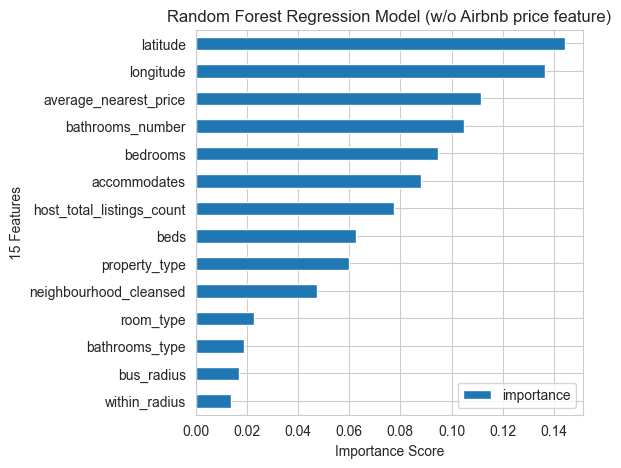

In [65]:
feat_imp = pd.DataFrame({'importance':rf.feature_importances_})  
feat_imp['feature'] = X_train_1.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)

feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
# feat_imp = feat_imp[len(feat_imp1)-15:len(feat_imp1)]
feat_imp.plot.barh(figsize=(5,5))
plt.xlabel('Importance Score')
plt.ylabel('15 Features')
plt.title('Random Forest Regression Model (w/o Airbnb price feature)')
plt.show()

In [33]:
mse = sklearn.metrics.mean_squared_error(y_test_1, y_predict_rf)  
mae_rf_1 = sklearn.metrics.mean_absolute_error(y_test_1, y_predict_rf) 

rmse_rf_1 = math.sqrt(mse)  

print("RMSE = ", rmse_rf_1)
print("MAE = ", mae_rf_1)

RMSE =  56.91306665867749
MAE =  42.68666099670097


In [34]:
shap.initjs()

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_1)

shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_1.iloc[0,:])

### 2. Decision tree regression

In [35]:
decision_tree = DecisionTreeRegressor(criterion='squared_error', max_depth = 20, random_state=42)

decision_tree.fit(X_train_1, y_train_1)
y_predict_dt = decision_tree.predict(X_test_1)

In [36]:
importancesRF = decision_tree.feature_importances_
feat_imp1 = pd.DataFrame(importancesRF, columns=['Weight'], index=X_train_1.columns)
feat_imp1.sort_values('Weight', inplace=True, ascending=False)
feat_imp1.head(5)

,Weight
bedrooms,0.215693
latitude,0.169687
longitude,0.134772
average_nearest_price,0.110548
bathrooms_number,0.091099


In [37]:
# feat_imp = pd.DataFrame({'importance':decision_tree.feature_importances_})  
# feat_imp['feature'] = X_train_1.columns
# feat_imp.sort_values(by='importance', ascending=False, inplace=True)

# feat_imp.sort_values(by='importance', inplace=True)
# feat_imp = feat_imp.set_index('feature', drop=True)
# feat_imp = feat_imp[len(feat_imp1)-15:len(feat_imp1)]
# feat_imp.plot.barh(figsize=(5,5))
# plt.xlabel('Importance Score')
# plt.ylabel('15 Features')
# plt.show()

In [38]:
mse = sklearn.metrics.mean_squared_error(y_test_1, y_predict_dt)  
mae_dt_1 = sklearn.metrics.mean_absolute_error(y_test_1, y_predict_dt) 

rmse_dt_1 = math.sqrt(mse)  

print("RMSE = ", rmse_dt_1)
print("MAE = ", mae_dt_1)

RMSE =  74.11336558392053
MAE =  53.26491063284723


### 3. Gradient boosting regression

In [39]:
grad_boosting_tree = GradientBoostingRegressor(n_estimators=50, learning_rate = 0.06, max_features = 'sqrt', 
                                               max_depth = 50, random_state=42)

grad_boosting_tree.fit(X_train_1, y_train_1)
y_predict_gb = grad_boosting_tree.predict(X_test_1)

In [40]:
importancesRF = grad_boosting_tree.feature_importances_
feat_imp1 = pd.DataFrame(importancesRF, columns=['Weight'], index=X_train_1.columns)
feat_imp1.sort_values('Weight', inplace=True, ascending=False)
feat_imp1.head(5)

,Weight
latitude,0.146933
longitude,0.141052
average_nearest_price,0.116343
bedrooms,0.108516
bathrooms_number,0.089339


In [41]:
# feat_imp = pd.DataFrame({'importance':grad_boosting_tree.feature_importances_})  
# feat_imp['feature'] = X_train_1.columns
# feat_imp.sort_values(by='importance', ascending=False, inplace=True)

# feat_imp.sort_values(by='importance', inplace=True)
# feat_imp = feat_imp.set_index('feature', drop=True)
# feat_imp = feat_imp[len(feat_imp1)-15:len(feat_imp1)]
# feat_imp.plot.barh(figsize=(5,5))
# plt.xlabel('Importance Score')
# plt.ylabel('15 Features')
# plt.show()

In [42]:
mse = sklearn.metrics.mean_squared_error(y_test_1, y_predict_gb)  
mae_gb_1 = sklearn.metrics.mean_absolute_error(y_test_1, y_predict_gb) 

rmse_gb_1 = math.sqrt(mse)  

print("RMSE = ", rmse_gb_1)
print("MAE = ", mae_gb_1)

RMSE =  57.38417201732336
MAE =  42.945569042043985


In [43]:
# explainer = shap.TreeExplainer(grad_boosting_tree)
# shap_values = explainer.shap_values(X_test_1)

# shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_1.iloc[0,:])

## Model Trained with average nearby listing price feature

In [44]:
X_test_2 = pd.read_csv('preprocessed_2_X_test_2.csv', sep=',')
y_test_2 = pd.read_csv('preprocessed_2_y_test_2.csv', sep=',')
X_train_2 = pd.read_csv('preprocessed_2_X_train.csv', sep=',')
y_train_2 = pd.read_csv('preprocessed_2_y_train.csv', sep=',')

### 1. Random forest regression

In [45]:
rf_2 = RandomForestRegressor(n_estimators = 30, max_features = 'sqrt', max_depth = 50, random_state=42)
rf_2.fit(X_train_2, y_train_2)
y_predict_rf_2 = rf_2.predict(X_test_2)

In [46]:
importancesRF = rf_2.feature_importances_
feat_imp1 = pd.DataFrame(importancesRF, columns=['Weight'], index=X_train_2.columns)
feat_imp1.sort_values('Weight', inplace=True, ascending=False)
feat_imp1.head(5)

,Weight
nearest_airbnb_price_8,0.235771
latitude,0.097502
bathrooms_number,0.091623
longitude,0.090007
bedrooms,0.084665


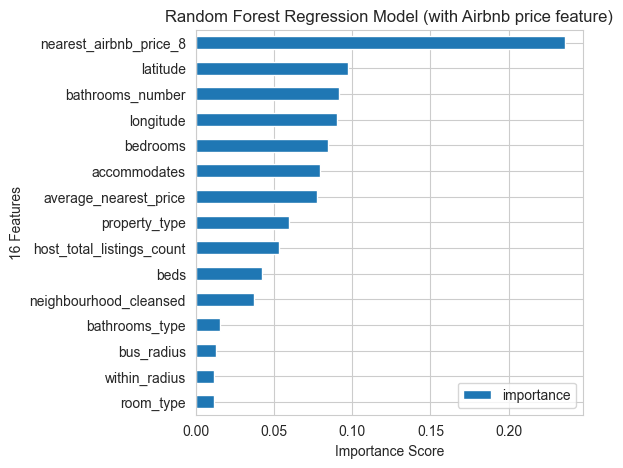

In [64]:
feat_imp = pd.DataFrame({'importance':rf_2.feature_importances_})  
feat_imp['feature'] = X_train_2.columns

feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
# feat_imp = feat_imp[len(feat_imp1)-16:len(feat_imp1)]
feat_imp.plot.barh(figsize=(5,5))
plt.xlabel('Importance Score')
plt.ylabel('16 Features')
plt.title('Random Forest Regression Model (with Airbnb price feature)')
plt.show()

In [48]:
feat_imp = pd.DataFrame({'importance':rf_2.feature_importances_})  
feat_imp['feature'] = X_train_2.columns
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp = feat_imp[len(feat_imp1)-16:len(feat_imp1)]
feat_imp

,importance
feature,
nearest_airbnb_price_8,0.235771


In [49]:
mse = sklearn.metrics.mean_squared_error(y_test_2, y_predict_rf_2)  
mae_rf_2 = sklearn.metrics.mean_absolute_error(y_test_2, y_predict_rf_2) 

rmse_rf_2 = math.sqrt(mse)  

print("RMSE = ", rmse_rf_2)
print("MAE = ", mae_rf_2)

RMSE =  45.71868118060634
MAE =  30.54693121693122


In [50]:
explainer = shap.TreeExplainer(rf_2)
shap_values = explainer.shap_values(X_test_2)

shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_2.iloc[0,:])

### 2. Decision tree regression

In [51]:
decision_tree_2 = DecisionTreeRegressor(max_depth = 30, random_state=42)

decision_tree_2.fit(X_train_2, y_train_2)
y_predict_dt_2 = decision_tree_2.predict(X_test_2)

In [52]:
importancesRF = decision_tree_2.feature_importances_
feat_imp1 = pd.DataFrame(importancesRF, columns=['Weight'], index=X_train_2.columns)
feat_imp1.sort_values('Weight', inplace=True, ascending=False)
feat_imp1.head(5)

,Weight
nearest_airbnb_price_8,0.337278
bedrooms,0.192395
average_nearest_price,0.085142
longitude,0.084634
latitude,0.081702


In [53]:
# feat_imp = pd.DataFrame({'importance':decision_tree_2.feature_importances_})  
# feat_imp['feature'] = X_train_2.columns
# feat_imp.sort_values(by='importance', ascending=False, inplace=True)

# feat_imp.sort_values(by='importance', inplace=True)
# feat_imp = feat_imp.set_index('feature', drop=True)
# feat_imp = feat_imp[len(feat_imp1)-16:len(feat_imp1)]
# feat_imp.plot.barh(figsize=(5,5))
# plt.xlabel('Importance Score')
# plt.ylabel('16 Features')
# plt.show()

In [54]:
mse = sklearn.metrics.mean_squared_error(y_test_2, y_predict_dt_2)  
mae_dt_2 = sklearn.metrics.mean_absolute_error(y_test_2, y_predict_dt_2) 

rmse_dt_2 = math.sqrt(mse)  

print("RMSE = ", rmse_dt_2)
print("MAE = ", mae_dt_2)

RMSE =  50.527907580310945
MAE =  35.67777777777778


### 3. Gradient boosting regression

In [55]:
grad_boosting_tree_2 = GradientBoostingRegressor(n_estimators=50, learning_rate = 0.06, max_features = 1, 
                                               max_depth = 50, random_state=42)

grad_boosting_tree_2.fit(X_train_2, y_train_2)
y_predict_gb_2 = grad_boosting_tree_2.predict(X_test_2)

In [56]:
importancesRF = grad_boosting_tree_2.feature_importances_
feat_imp1 = pd.DataFrame(importancesRF, columns=['Weight'], index=X_train_2.columns)
feat_imp1.sort_values('Weight', inplace=True, ascending=False)
feat_imp1.head(5)

,Weight
nearest_airbnb_price_8,0.175306
longitude,0.099982
latitude,0.095073
average_nearest_price,0.089091
accommodates,0.077667


In [57]:
# feat_imp = pd.DataFrame({'importance':grad_boosting_tree_2.feature_importances_})  
# feat_imp['feature'] = X_train_2.columns
# feat_imp.sort_values(by='importance', ascending=False, inplace=True)

# feat_imp.sort_values(by='importance', inplace=True)
# feat_imp = feat_imp.set_index('feature', drop=True)
# feat_imp = feat_imp[len(feat_imp1)-16:len(feat_imp1)]
# feat_imp.plot.barh(figsize=(5,5))
# plt.xlabel('Importance Score')
# plt.ylabel('16 Features')
# plt.show()

In [58]:
mse = sklearn.metrics.mean_squared_error(y_test_2, y_predict_gb_2)  
mae_gb_2 = sklearn.metrics.mean_absolute_error(y_test_2, y_predict_gb_2) 

rmse_gb_2 = math.sqrt(mse)  

print("RMSE = ", rmse_gb_2)
print("MAE = ", mae_gb_2)

RMSE =  43.496031515204386
MAE =  28.87457644404921


In [59]:
# explainer = shap.TreeExplainer(grad_boosting_tree_2)
# shap_values = explainer.shap_values(X_test_2)

# shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_2.iloc[0,:])

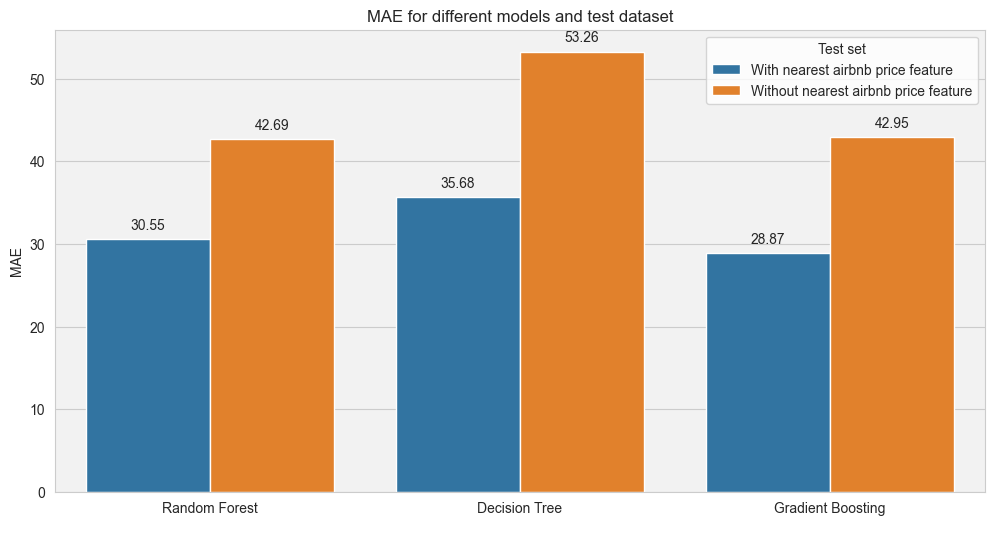

In [60]:
data = {' ': ['Random Forest', 'Random Forest', 'Decision Tree', 'Decision Tree',
                  'Gradient Boosting', 'Gradient Boosting'],
        'Test set': ['With nearest airbnb price feature', 'Without nearest airbnb price feature', 
                     'With nearest airbnb price feature', 'Without nearest airbnb price feature', 
                     'With nearest airbnb price feature', 'Without nearest airbnb price feature'],
        'MAE': [mae_rf_2, mae_rf_1, mae_dt_2, mae_dt_1, mae_gb_2, mae_gb_1]}
df_scores = pd.DataFrame(data)

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=" ", y="MAE", hue="Test set", data=df_scores)
ax.set_title('MAE for different models and test dataset')

ax.set_facecolor('#f2f2f2')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points', fontsize=10)
plt.savefig('barplot_mae.png', dpi=300, bbox_inches='tight')

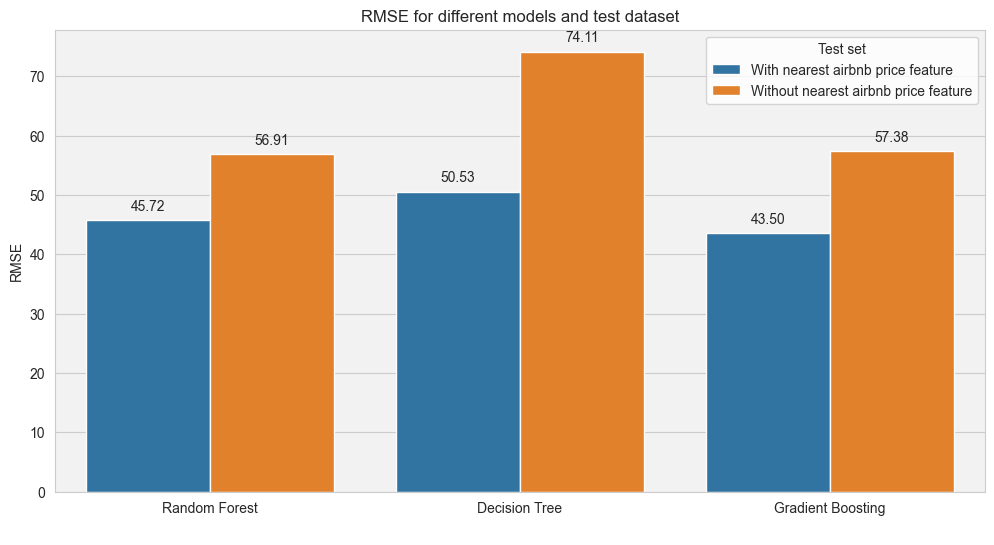

In [61]:
data = {' ': ['Random Forest', 'Random Forest', 'Decision Tree', 'Decision Tree',
                  'Gradient Boosting', 'Gradient Boosting'],
        'Test set': ['With nearest airbnb price feature', 'Without nearest airbnb price feature', 
                     'With nearest airbnb price feature', 'Without nearest airbnb price feature', 
                     'With nearest airbnb price feature', 'Without nearest airbnb price feature'],
        'RMSE': [rmse_rf_2, rmse_rf_1, rmse_dt_2, rmse_dt_1, rmse_gb_2, rmse_gb_1]}
df_scores = pd.DataFrame(data)

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=" ", y="RMSE", hue="Test set", data=df_scores)
ax.set_title('RMSE for different models and test dataset')

ax.set_facecolor('#f2f2f2')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points', fontsize=10)
plt.savefig('barplot_rmse.png', dpi=300, bbox_inches='tight')

#### Random Forest

Random Forest is an emsemble technique that is able to perform Regression tasks with the use of multiple decision trees and a technique that is called Bootstrap aggregation (Bagging). The idea behind this technique is to combine multiple results of decision trees in its prediction rather than replying on individual decision trees, thus reduces the variance.

Importance provides a score that indicates how useful or important each feature was in the construction of the decision trees within the model. The higher its relative importance, the more a variable is used to make key decisions within decision trees.

Therefore, feature importance can be used to interpret our data to understand the most important features that define our predictions. In this case, looking at the bar chart above, the predictor variable that is associated with a longer bar means that the variable has a higher importance in the Random Tree Regression Model in predicting price.